In [1]:
from lisa.utils import *
from lisa.library import *
import lisa.models, pytz
import numpy as np, pandas as pd, datetime
from matplotlib import pyplot as plt, style # for ploting
import seaborn as sns # for ploting
from sklearn.metrics import fbeta_score, precision_score, recall_score, confusion_matrix # for evaluation
import itertools

In [2]:
style.use('ggplot')
np.random.seed(42) 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Copyed from a kernel by joparga3 https://www.kaggle.com/joparga3/kernels
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
datastream = DataSet.objects.get(id=6)
df = datastream.dataframe
df_z = df_zscore(df)
df_res = pd.DataFrame(index=df_z.index, columns=df_z.columns)
df_mean = df_z.mean(axis=1)
df_std = df_z.std(axis=1)
df_quantile_25 = df_z.quantile(0.25, axis=1)
df_quantile_75 = df_z.quantile(0.75, axis=1)

In [4]:
count=0
for index, row in df_z.iterrows():
    for column in df_z.columns:
        IQR = df_quantile_75[index] - df_quantile_25[index]
        
        if row[column] < (df_quantile_25[index] - (3 * IQR)) or row[column] > (df_quantile_75[index] + (3 * IQR)):
            df_res.loc[index, column] = 1
            count+=1
            #print(index)
            #print('Val:', np.abs(row[column]))
            #print('Mean:', df_mean[index])
            #print('2 Std:', 2*df_std[index])
print(count)
print(df_res.sum(axis=0))

145
station
23    22.0
24     8.0
25     7.0
26     NaN
27    52.0
28     4.0
29     NaN
30     NaN
31     NaN
32     3.0
33    20.0
34     1.0
35    27.0
37     1.0
dtype: float64


In [5]:
indexes = []
for index, row in df_res.iterrows():
    for column in df_res.columns:
        if row[column] == 1:
            indexes.append(index)
            break
print(len(indexes))

115


In [6]:
df_class = pd.DataFrame(index=df.index)
df_class['Class'] = 0

for index in indexes:
    df_class.loc[index,'Class'] = 1
df = df.join(df_class)

In [7]:
normal = df[df['Class'] == 0]
anomaly = df[df['Class'] == 1]

In [8]:
from sklearn.model_selection import train_test_split

train, normal_test, _, _ = train_test_split(normal, normal, test_size=.2, random_state=42)

normal_valid, normal_test, _, _ = train_test_split(normal_test, normal_test, test_size=.5, random_state=42)
anormal_valid, anormal_test, _, _ = train_test_split(anomaly, anomaly, test_size=.5, random_state=42)

train = train.reset_index(drop=True)
valid = normal_valid.append(anormal_valid).sample(frac=1).reset_index(drop=True)
test = normal_test.append(anormal_test).sample(frac=1).reset_index(drop=True)

print('Train shape: ', train.shape)
print('Proportion os anomaly in training set: %.2f\n' % train['Class'].mean())
print('Valid shape: ', valid.shape)
print('Proportion os anomaly in validation set: %.2f\n' % valid['Class'].mean())
print('Test shape:, ', test.shape)
print('Proportion os anomaly in test set: %.2f\n' % test['Class'].mean())

Train shape:  (1520, 15)
Proportion os anomaly in training set: 0.00

Valid shape:  (247, 15)
Proportion os anomaly in validation set: 0.23

Test shape:,  (249, 15)
Proportion os anomaly in test set: 0.23



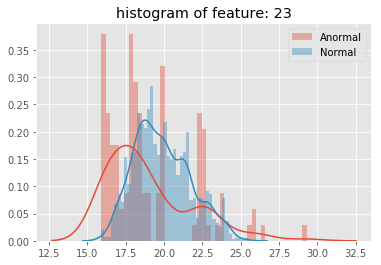

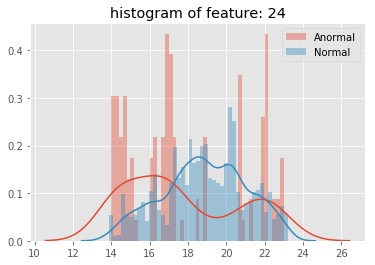

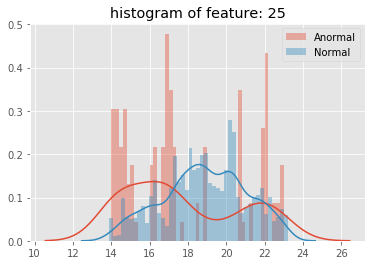

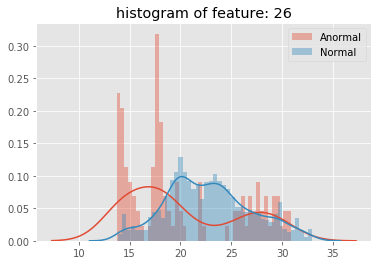

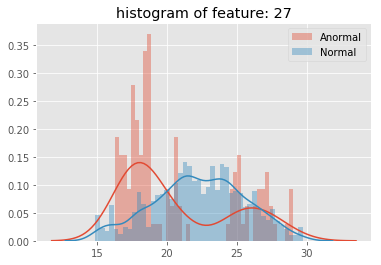

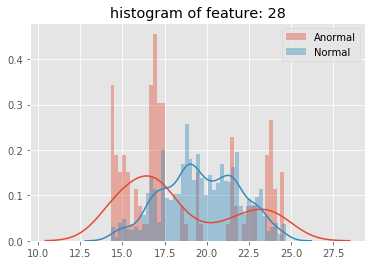

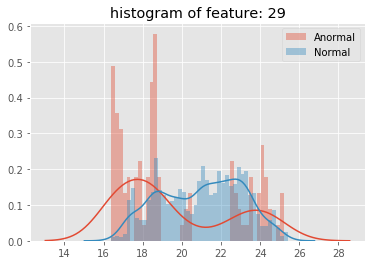

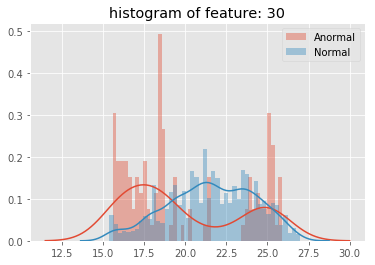

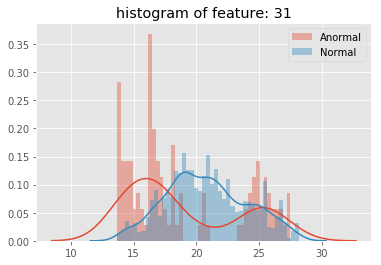

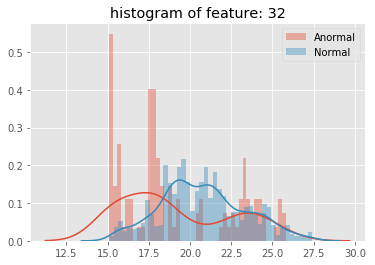

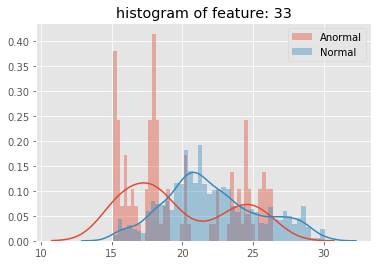

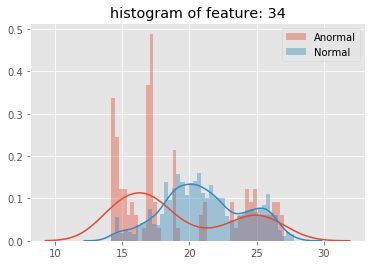

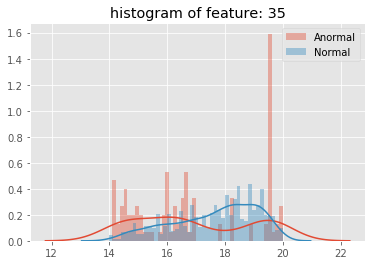

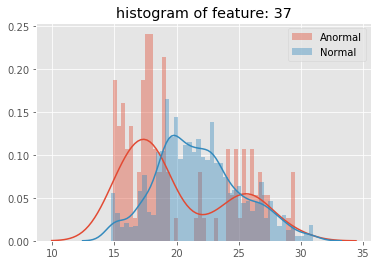

In [9]:
import matplotlib.gridspec as gridspec

# plt.figure(figsize=(12,28*5))
# gs = gridspec.GridSpec(28, 1)
for feature in df.drop(['Class'], axis=1).columns:
    ax = plt.subplot()
    sns.distplot(df[feature][df.Class == 1], bins=45, label='Anormal')
    sns.distplot(df[feature][df.Class == 0], bins=45, label='Normal')
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(feature))
    plt.legend(loc='best')
    plt.show()

In [10]:
class hist_model(object):
    
    def __init__(self, bins=50):
        self.bins = bins
        
    def fit(self, X):
        
        bin_hight, bin_edge = [], []
        
        for var in X.T:
            # get bins hight and interval
            bh, bedge = np.histogram(var, bins=self.bins)
            bin_hight.append(bh)
            bin_edge.append(bedge)
        
        self.bin_hight = np.array(bin_hight)
        self.bin_edge = np.array(bin_edge)
   

    def predict(self, X):
        
        scores = []
        for obs in X:
            obs_score = []
            for i, var in enumerate(obs):
                # find wich bin obs is in
                bin_num = (var > self.bin_edge[i]).argmin()-1
                obs_score.append(self.bin_hight[i, bin_num]) # find bin hitght
            
            scores.append(np.mean(obs_score))
        
        return np.array(scores)
                

        
model = hist_model()
model.fit(train.drop('Class', axis=1).values)
print(np.median(model.predict(valid[valid['Class'] == 0].drop('Class', axis=1).values))) 
print(np.median(model.predict(valid[valid['Class'] == 1].drop('Class', axis=1).values))) 

43.2857142857
27.0714285714


In [13]:
tresholds = np.linspace(15, 45, 100)
scores = []
y_pred_score = model.predict(valid.drop('Class', axis=1).values)
for treshold in tresholds:
    y_hat = (y_pred_score < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=valid['Class'].values),
                 precision_score(y_pred=y_hat, y_true=valid['Class'].values),
                 fbeta_score(y_pred=y_hat, y_true=valid['Class'].values, beta=1)])

scores = np.array(scores)

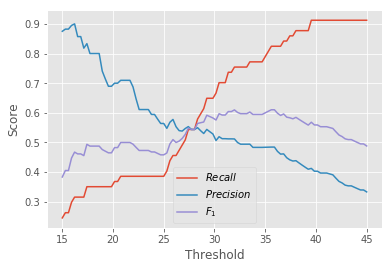

In [14]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_1$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

Final threshold: 35
Test Recall Score: 0.783
Test Precision Score: 0.139
Test F1 Score: 0.236


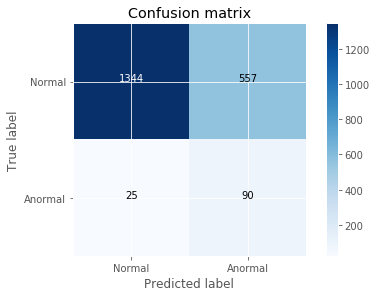

In [15]:
final_tresh = tresholds[scores[:, 2].argmax()]
df_n = df.reset_index(drop=True)
y_hat_test = (model.predict(df_n.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=df_n['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=df_n['Class'].values, beta=1))

cnf_matrix = confusion_matrix(df_n['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')

In [16]:
#gets all anormal instances
df[(model.predict(df_n.drop('Class', axis=1).values) < final_tresh)].shape

(647, 15)

Final threshold: 21
Test Recall Score: 0.468
Test Precision Score: 0.283
Test F1 Score: 0.353


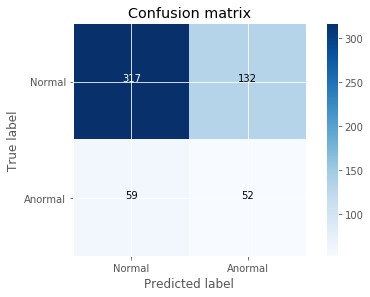

In [41]:
final_tresh = tresholds[scores[:, 2].argmax()]
y_hat_test = (model.predict(test.drop('Class', axis=1).values) < final_tresh).astype(int)

print('Final threshold: %d' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=test['Class'].values))
print('Test F1 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=test['Class'].values, beta=1))

cnf_matrix = confusion_matrix(test['Class'].values, y_hat_test)
plot_confusion_matrix(cnf_matrix, classes=['Normal','Anormal'], title='Confusion matrix')